<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Reproducible Papers - Syngine Paper</div>
        </div>
    </div>
</div>

---

# Figure 6:  Data Quality - Detecting Wrong Times with Synthetics

This notebook is part of the supplementary materials for the Syngine paper and reproduces figure 6.

This notebook creates the phase relative times figure. Requires matplotlib >= 1.5 and an ObsPy version (>= 1.0) with the syngine client as well as instaseis.

##### Authors:
* Lion Krischer ([@krischer](https://github.com/krischer))

In [1]:
%matplotlib inline

In [2]:
import obspy
import numpy as np
from obspy.clients.fdsn import Client
from obspy.clients.syngine import Client as SyngineClient

import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.style.use("seaborn-paper")

In [3]:
c_iris = Client("IRIS")

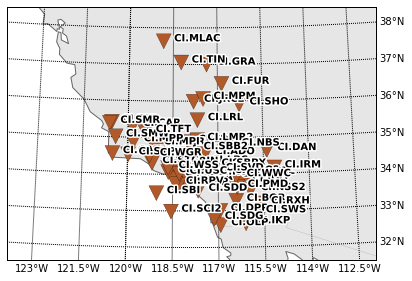

Inventory created at 2016-11-14T23:27:30.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.20
		    http://service.iris.edu/fdsnws/station/1/query?level=response&endaf...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			CI
		Stations (63):
			CI.ADO (Adelanto Receiving)
			CI.BEL (Belle Mountain Joshua Tree)
			CI.BFS (Mt. Baldy Ranger Station)
			CI.BOR (Borrego Springs)
			CI.CAR (Carrizo Plain)
			CI.DAN (Danby)
			CI.DEC (Green Verdugo Site)
			CI.DEV (Devers)
			CI.DJJ (Donna Jones Jenkins, Sherman Oaks, CA, USA)
			CI.DLA (Del Amo)
			CI.DPP (Dos Picos County Park)
			CI.EDW2 (Edwards 2)
			CI.FMP (Fort Macarthur Park)
			CI.FUR (Furnace Creek)
			CI.GATR (GATR Compound)
			CI.GRA (Grapevine Ranger Station)
			CI.IDO (Indio Hill)
			CI.IKP (In-Ko-Pah)
			CI.IRM (Iron Mountain)
			CI.JRC2 (Joshua Ridge: China Lake)
			CI.LJR (Lone Juniper Ranch, Gorman, CA, USA)
			CI.LMR2 (Leuhmann Ridge Extension)
			CI.LPC (Lone Pine Canyon)
			CI.LRL (

In [4]:
# Get all stations from the Caltech Regional Seismic Network activate
# at the given time.
inv = c_iris.get_stations(level="response", format="xml", channel="BHZ",
                          network="CI", location="  ",
                          startbefore=obspy.UTCDateTime(2012, 1, 1),
                          endafter=obspy.UTCDateTime(2016, 1, 1))
inv.plot(projection="local");
print(inv)

5 Event(s) in Catalog:
2012-03-09T07:10:00.410000Z | -19.060, +169.600 | 6.63 mw
2012-12-21T22:28:12.370000Z | -14.310, +167.170 | 6.68 mw
2014-01-01T16:03:34.800000Z | -13.890, +167.100 | 6.53 mw
2015-01-23T03:47:33.400000Z | -17.060, +168.360 | 6.78 mw
2015-10-20T21:52:07.920000Z | -14.880, +167.190 | 7.11 mw


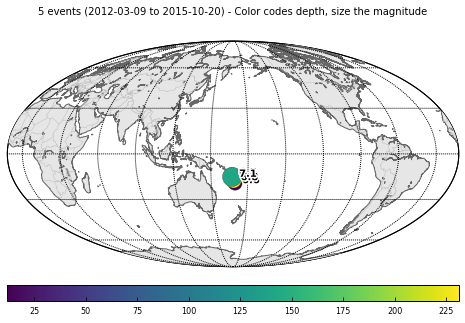

In [5]:
# Downloaded from the GCMT page.
cat = obspy.read_events("./cmtsolutions.txt", format="CMTSOLUTION").filter("latitude > -20", "longitude > 165")

# This is a demo - we thus are very selective regarding which data we use...

training = ["smi:local/cmtsolution/201510202152A/event",
            "smi:local/cmtsolution/201212212228A/event",
            "smi:local/cmtsolution/201203090709A/event"]
validate = "smi:local/cmtsolution/201401011603A/event"
application = "smi:local/cmtsolution/201501230347A/event"

all_data = []
all_data.extend(training)
all_data.append(validate)
all_data.append(application)

cat.events = [_i for _i in cat.events if _i.resource_id.id in all_data]

print(cat)
cat.plot();

In [6]:
# For all of them: download the syngine data 50 seconds before the p-phase
# and 50 seconds after for the 5s ak135f DB.
c_syngine = SyngineClient()

In [7]:
# Download all syngine data.
synthetic_data = {}

bulk = [
    {"networkcode": "CI", "stationcode": _i.code,
     "latitude": _i.latitude, "longitude": _i.longitude} for _i in inv[0]]

for _i, event in enumerate(cat):
    origin = [_i for _i in event.origins if _i.origin_type == "hypocenter"][0]
    mt = event.focal_mechanisms[0].moment_tensor.tensor
    print("Downloading data for event %i of %i ..." % (_i + 1, len(cat)))
    st_syn = c_syngine.get_waveforms_bulk(
        model="ak135f_5s", bulk=bulk, sourcelatitude=origin.latitude,
        sourcelongitude=origin.longitude, sourcedepthinmeters=origin.depth,
        sourcemomenttensor=[mt.m_rr, mt.m_tt, mt.m_pp, mt.m_rt, mt.m_rp, mt.m_tp],
        origintime=origin.time,
        components="Z",
        # Avoid downsampling - just upsample to the data sampling rate.
        dt=1.0 / 40.0,
        kernelwidth=10,
        units="velocity",
        starttime="P-50", endtime="P+50")
    
    this_event = {"event_object": event, "stream": st_syn}
    synthetic_data[event.resource_id] = this_event
    print("  -> Downloaded %i synthetic traces." % len(st_syn))

  -> Downloaded 63 synthetic traces.
  -> Downloaded 63 synthetic traces.
  -> Downloaded 63 synthetic traces.
  -> Downloaded 63 synthetic traces.
  -> Downloaded 63 synthetic traces.


In [8]:
# Reordering ... I don't want to redownload again...
data = synthetic_data
for value in data.values():
    value["synthetic_stream"] = value["stream"]
    del value["stream"]

In [9]:
# Now download all real data.
for _i, value in enumerate(data.values()):
    print("Downloading data for event %i of %i ..." % (_i + 1, len(cat)))
    st_obs = c_iris.get_waveforms_bulk(
        [(tr.stats.network, tr.stats.station, "",
          "BHZ", tr.stats.starttime, tr.stats.endtime) for tr in value["synthetic_stream"]])
    value["observed_stream"] = st_obs
    print("  -> Downloaded %i observed traces." % len(st_obs))

  -> Downloaded 25 observed traces.
  -> Downloaded 25 observed traces.
  -> Downloaded 25 observed traces.
  -> Downloaded 25 observed traces.
  -> Downloaded 23 observed traces.


In [10]:
# Cleanup - here we make our job easy and just remove all
# stations for which we don't have data for all events.
# Real implementations will of course have to deal with this.

common_stations = set.intersection(*[set((tr.stats.network, tr.stats.station)
                                         for tr in value["observed_stream"])
                                     for value in data.values()])
print(len(common_stations))

for value in data.values():
    value["observed_stream"] = obspy.Stream(traces=[
        tr for tr in value["observed_stream"] if 
        (tr.stats.network, tr.stats.station) in common_stations])
    value["synthetic_stream"] = obspy.Stream(traces=[
        tr for tr in value["synthetic_stream"] if 
        (tr.stats.network, tr.stats.station) in common_stations])

23


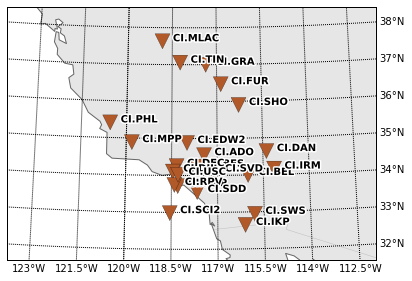

In [11]:
# Create a new inventory object which only contains the common stations.
from copy import deepcopy
filtered_inv = deepcopy(inv)
filtered_inv[0].stations = [_i for _i in filtered_inv[0].stations if ("CI", _i.code) in common_stations]
filtered_inv.plot(projection="local");

In [12]:
from obspy.signal.cross_correlation import xcorr_pick_correction


collected_stats = []

good_data = data

# Now calculate the P phase delay for all stations.
for network, station in common_stations:
    print(network, station)
    for event, this_data in good_data.items():
        obs_tr = this_data["observed_stream"].select(network=network, station=station)[0].copy()
        syn_tr = this_data["synthetic_stream"].select(network=network, station=station)[0].copy()
        
        # Artificially shift the data for two stations for the "application" event.
        if event.id == application:
            if station == "BEL":
                obs_tr.stats.starttime -= 1.0
            if station == "PHL":
                obs_tr.stats.starttime += 1.0
              
        # p-phase should be centered in the synthetic trace.
        pick = syn_tr.stats.starttime + (syn_tr.stats.endtime - syn_tr.stats.starttime) / 2.0
        
        # Process data.
        obs_tr.detrend("linear")\
            .taper(max_percentage=0.05, type="hann")\
            .remove_response(inventory=filtered_inv, pre_filt=(0.02, 0.01, 1, 5))\
            .filter("bandpass", freqmin=0.08, freqmax=0.2, corners=4, zerophase=True)\
            ._ltrim(30.0)\
            ._rtrim(30.0)\
            .taper(max_percentage=0.3, type="hann")
        obs_tr.trim(obs_tr.stats.starttime - 50, obs_tr.stats.endtime + 50, pad=True, fill_value=0.0)
        
        # Also filter the synthetics.
        syn_tr.taper(max_percentage=0.05, type="hann")
        syn_tr.filter("bandpass", freqmin=0.08, freqmax=0.2, corners=4, zerophase=True)
        syn_tr.data = np.require(syn_tr, requirements=["C"])
        
        # Interpolate both to the same sample points.
        starttime = max(obs_tr.stats.starttime, syn_tr.stats.starttime)
        endtime = min(obs_tr.stats.endtime, syn_tr.stats.endtime)
        npts = (endtime - starttime) // (1.0 / 40.0) - 1
        obs_tr.interpolate(sampling_rate=40.0, method="lanczos", a=5,
                           starttime=starttime, npts=npts)
        syn_tr.interpolate(sampling_rate=40.0, method="lanczos", a=5,
                           starttime=starttime, npts=npts)
        
        print(event.id, network, station)
        
        # Subsample precision.
        try:
            shift, corr = xcorr_pick_correction(pick, obs_tr, pick, syn_tr, t_before=20,
                                                t_after=20, cc_maxlag=12)
        except:
            shift, corr = None, None
        collected_stats.append({"time_shift": shift, "correlation": corr,
                                "network": network, "station": station, "event": event.id})
        
        if "processed_observed_stream" not in this_data:
            this_data["processed_observed_stream"] = obspy.Stream()
            
        this_data["processed_observed_stream"] += obs_tr
        
        if "processed_synthetic_stream" not in this_data:
            this_data["processed_synthetic_stream"] = obspy.Stream()
            
        this_data["processed_synthetic_stream"] += syn_tr


CI MLAC
smi:local/cmtsolution/201212212228A/event CI MLAC
smi:local/cmtsolution/201401011603A/event CI MLAC
smi:local/cmtsolution/201203090709A/event CI MLAC


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/interpolation.py:304: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return_data = np.zeros(new_npts, dtype=np.float64)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.MLAC..BHZ != CI.MLAC.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7344883209114442
  warnings.warn(msg)


smi:local/cmtsolution/201501230347A/event CI MLAC
smi:local/cmtsolution/201510202152A/event CI MLAC
CI EDW2
smi:local/cmtsolution/201212212228A/event CI EDW2
smi:local/cmtsolution/201401011603A/event CI EDW2
smi:local/cmtsolution/201203090709A/event CI EDW2


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.EDW2..BHZ != CI.EDW2.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7385561274634416
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.SCI2..BHZ != CI.SCI2.SE.BXZ
  warnings.warn(msg)


smi:local/cmtsolution/201501230347A/event CI EDW2
smi:local/cmtsolution/201510202152A/event CI EDW2
CI SCI2
smi:local/cmtsolution/201212212228A/event CI SCI2
smi:local/cmtsolution/201401011603A/event CI SCI2
smi:local/cmtsolution/201203090709A/event CI SCI2
smi:local/cmtsolution/201501230347A/event CI SCI2


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.6441688542274444
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.SDD..BHZ != CI.SDD.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7010417485173137
  warnings.warn(msg)


smi:local/cmtsolution/201510202152A/event CI SCI2
CI SDD
smi:local/cmtsolution/201212212228A/event CI SDD
smi:local/cmtsolution/201401011603A/event CI SDD
smi:local/cmtsolution/201203090709A/event CI SDD
smi:local/cmtsolution/201501230347A/event CI SDD
smi:local/cmtsolution/201510202152A/event CI SDD
CI RPV
smi:local/cmtsolution/201212212228A/event CI RPV
smi:local/cmtsolution/201401011603A/event CI RPV
smi:local/cmtsolution/201203090709A/event CI RPV
smi:local/cmtsolution/201501230347A/event CI RPV
smi:local/cmtsolution/201510202152A/event CI RPV
CI SHO
smi:local/cmtsolution/201212212228A/event CI SHO


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.RPV..BHZ != CI.RPV.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7368502909377028
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.SHO..BHZ != CI.SHO.SE.BXZ
  warnings.warn(msg)


smi:local/cmtsolution/201401011603A/event CI SHO
smi:local/cmtsolution/201203090709A/event CI SHO
smi:local/cmtsolution/201501230347A/event CI SHO
smi:local/cmtsolution/201510202152A/event CI SHO
CI BEL
smi:local/cmtsolution/201212212228A/event CI BEL
smi:local/cmtsolution/201401011603A/event CI BEL


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7225012912970106
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.BEL..BHZ != CI.BEL.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7456006375765655
  warnings.warn(msg)


smi:local/cmtsolution/201203090709A/event CI BEL
smi:local/cmtsolution/201501230347A/event CI BEL
smi:local/cmtsolution/201510202152A/event CI BEL
CI FMP
smi:local/cmtsolution/201212212228A/event CI FMP
smi:local/cmtsolution/201401011603A/event CI FMP
smi:local/cmtsolution/201203090709A/event CI FMP
smi:local/cmtsolution/201501230347A/event CI FMP


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.FMP..BHZ != CI.FMP.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7400267015393122
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.USC..BHZ != CI.USC.SE.BXZ
  warnings.warn(msg)


smi:local/cmtsolution/201510202152A/event CI FMP
CI USC
smi:local/cmtsolution/201212212228A/event CI USC
smi:local/cmtsolution/201401011603A/event CI USC
smi:local/cmtsolution/201203090709A/event CI USC
smi:local/cmtsolution/201501230347A/event CI USC
smi:local/cmtsolution/201510202152A/event CI USC
CI SVD


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7607620783386363
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.SVD..BHZ != CI.SVD.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7573765076969339
  warnings.warn(msg)


smi:local/cmtsolution/201212212228A/event CI SVD
smi:local/cmtsolution/201401011603A/event CI SVD
smi:local/cmtsolution/201203090709A/event CI SVD
smi:local/cmtsolution/201501230347A/event CI SVD
smi:local/cmtsolution/201510202152A/event CI SVD
CI DJJ
smi:local/cmtsolution/201212212228A/event CI DJJ


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.DJJ..BHZ != CI.DJJ.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.732400177297203
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.BFS..BHZ != CI.BFS.SE.BXZ
  warnings.warn(msg)


smi:local/cmtsolution/201401011603A/event CI DJJ
smi:local/cmtsolution/201203090709A/event CI DJJ
smi:local/cmtsolution/201501230347A/event CI DJJ
smi:local/cmtsolution/201510202152A/event CI DJJ
CI BFS
smi:local/cmtsolution/201212212228A/event CI BFS
smi:local/cmtsolution/201401011603A/event CI BFS
smi:local/cmtsolution/201203090709A/event CI BFS
smi:local/cmtsolution/201501230347A/event CI BFS
smi:local/cmtsolution/201510202152A/event CI BFS
CI IKP
smi:local/cmtsolution/201212212228A/event CI IKP
smi:local/cmtsolution/201401011603A/event CI IKP
smi:local/cmtsolution/201203090709A/event CI IKP


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.713456098813435
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.IKP..BHZ != CI.IKP.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7558428458578529
  warnings.warn(msg)


smi:local/cmtsolution/201501230347A/event CI IKP
smi:local/cmtsolution/201510202152A/event CI IKP
CI FUR
smi:local/cmtsolution/201212212228A/event CI FUR
smi:local/cmtsolution/201401011603A/event CI FUR
smi:local/cmtsolution/201203090709A/event CI FUR
smi:local/cmtsolution/201501230347A/event CI FUR
smi:local/cmtsolution/201510202152A/event CI FUR


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.FUR..BHZ != CI.FUR.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7391909762787343
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.IRM..BHZ != CI.IRM.SE.BXZ
  warnings.warn(msg)


CI IRM
smi:local/cmtsolution/201212212228A/event CI IRM
smi:local/cmtsolution/201401011603A/event CI IRM
smi:local/cmtsolution/201203090709A/event CI IRM
smi:local/cmtsolution/201501230347A/event CI IRM
smi:local/cmtsolution/201510202152A/event CI IRM
CI DEC


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7196908135806419
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.DEC..BHZ != CI.DEC.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7385392394530239
  warnings.warn(msg)


smi:local/cmtsolution/201212212228A/event CI DEC
smi:local/cmtsolution/201401011603A/event CI DEC
smi:local/cmtsolution/201203090709A/event CI DEC
smi:local/cmtsolution/201501230347A/event CI DEC
smi:local/cmtsolution/201510202152A/event CI DEC
CI SWS
smi:local/cmtsolution/201212212228A/event CI SWS


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.SWS..BHZ != CI.SWS.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7188024157155695
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.ADO..BHZ != CI.ADO.SE.BXZ
  warnings.warn(msg)


smi:local/cmtsolution/201401011603A/event CI SWS
smi:local/cmtsolution/201203090709A/event CI SWS
smi:local/cmtsolution/201501230347A/event CI SWS
smi:local/cmtsolution/201510202152A/event CI SWS
CI ADO
smi:local/cmtsolution/201212212228A/event CI ADO
smi:local/cmtsolution/201401011603A/event CI ADO
smi:local/cmtsolution/201203090709A/event CI ADO
smi:local/cmtsolution/201501230347A/event CI ADO
smi:local/cmtsolution/201510202152A/event CI ADO
CI GRA
smi:local/cmtsolution/201212212228A/event CI GRA
smi:local/cmtsolution/201401011603A/event CI GRA
smi:local/cmtsolution/201203090709A/event CI GRA


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.676194290695628
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.GRA..BHZ != CI.GRA.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7510553224883983
  warnings.warn(msg)


smi:local/cmtsolution/201501230347A/event CI GRA
smi:local/cmtsolution/201510202152A/event CI GRA
CI TIN
smi:local/cmtsolution/201212212228A/event CI TIN
smi:local/cmtsolution/201401011603A/event CI TIN
smi:local/cmtsolution/201203090709A/event CI TIN
smi:local/cmtsolution/201501230347A/event CI TIN
smi:local/cmtsolution/201510202152A/event CI TIN


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.TIN..BHZ != CI.TIN.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7488312490480352
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.MPP..BHZ != CI.MPP.SE.BXZ
  warnings.warn(msg)


CI MPP
smi:local/cmtsolution/201212212228A/event CI MPP
smi:local/cmtsolution/201401011603A/event CI MPP
smi:local/cmtsolution/201203090709A/event CI MPP
smi:local/cmtsolution/201501230347A/event CI MPP
smi:local/cmtsolution/201510202152A/event CI MPP
CI DAN


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7334524020204608
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.DAN..BHZ != CI.DAN.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.7426297533595667
  warnings.warn(msg)


smi:local/cmtsolution/201212212228A/event CI DAN
smi:local/cmtsolution/201401011603A/event CI DAN
smi:local/cmtsolution/201203090709A/event CI DAN
smi:local/cmtsolution/201501230347A/event CI DAN
smi:local/cmtsolution/201510202152A/event CI DAN
CI PHL
smi:local/cmtsolution/201212212228A/event CI PHL
smi:local/cmtsolution/201401011603A/event CI PHL
smi:local/cmtsolution/201203090709A/event CI PHL
smi:local/cmtsolution/201501230347A/event CI PHL
smi:local/cmtsolution/201510202152A/event CI PHL


/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:295: UserWarning: Trace ids do not match: CI.PHL..BHZ != CI.PHL.SE.BXZ
  warnings.warn(msg)
/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.741188944105587
  warnings.warn(msg)


In [13]:
import pandas
pandas.set_option('display.max_rows', 10)
cs = pandas.DataFrame(collected_stats)
original_cs = pandas.DataFrame(collected_stats)

In [14]:
# Now for all events: substract the mean time shift to account for
# unexplained structure and unknown origin time.
cs.loc[:, "time_shift"] = cs.groupby("event").time_shift.transform(lambda df: df - df.mean())
cs = cs.sort_values("station")
cs

,correlation,event,network,station,time_shift
85,0.958651,smi:local/cmtsolution/201212212228A/event,CI,ADO,0.015997
86,0.917029,smi:local/cmtsolution/201401011603A/event,CI,ADO,0.258976
87,0.664034,smi:local/cmtsolution/201203090709A/event,CI,ADO,0.074989
88,0.931687,smi:local/cmtsolution/201501230347A/event,CI,ADO,0.214235
89,0.940643,smi:local/cmtsolution/201510202152A/event,CI,ADO,0.201632
...,...,...,...,...,...
40,0.938013,smi:local/cmtsolution/201212212228A/event,CI,USC,0.169131
41,0.925283,smi:local/cmtsolution/201401011603A/event,CI,USC,-0.013476
42,0.747191,smi:local/cmtsolution/201203090709A/event,CI,USC,0.013855
43,0.948916,smi:local/cmtsolution/201501230347A/event,CI,USC,0.023827


In [15]:
# Calculate the reference time shift for each station.
reference_shifts = dict(cs.loc[cs.event.isin(training)].groupby("station").time_shift.mean())
reference_shifts

{'ADO': 0.097539550305467237,
 'BEL': -0.10811763665525269,
 'BFS': 0.054457279084864606,
 'DAN': -0.13825531931474591,
 'DEC': 0.29678977090362507,
 'DJJ': 0.24818900497196639,
 'EDW2': -0.046927983981473798,
 'FMP': 0.3097963189089265,
 'FUR': 0.26031455284817123,
 'GRA': 0.13341808955692361,
 'IKP': -0.35479395049249146,
 'IRM': -0.11532071631547651,
 'MLAC': -0.66965472277195026,
 'MPP': -0.66127424322112061,
 'PHL': -0.45885561907357869,
 'RPV': -0.016112838887453851,
 'SCI2': 0.45963884581321085,
 'SDD': 0.17358345968841338,
 'SHO': 0.25098140870381574,
 'SVD': 0.17079649417762907,
 'SWS': 0.045740267899711196,
 'TIN': -0.028978042068303306,
 'USC': 0.097046029919105603}

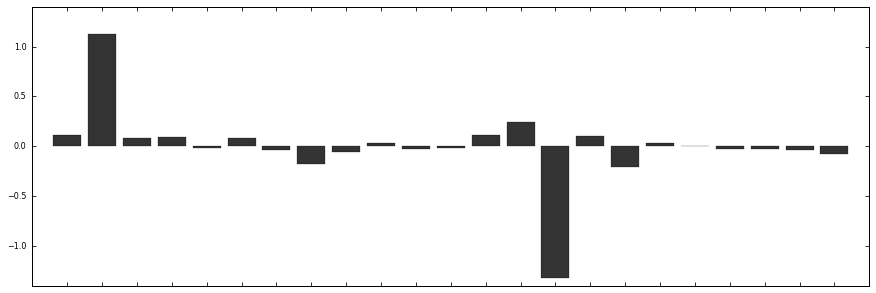

In [16]:
import matplotlib.pyplot as plt

def check_event(event, ax=None, ticks=False):
    _ds = cs[cs.event == event]
    mean = _ds.time_shift.mean()
    
    things = []

    for _i in _ds.itertuples():
        things.append({"station": _i.station,
                       "time_shift": _i.time_shift - mean,
                       "difference_to_mean": (_i.time_shift - mean) - reference_shifts[_i.station]})
        
    temp = pandas.DataFrame(things).sort_values("station")
    
    if ax is None:
        plt.figure(figsize=(15, 5))
        ax = plt.gca()
    plt.bar(np.arange(len(_ds)) - 0.4, temp.difference_to_mean, 0.8, color="0.2")
    plt.ylim(-1.4, 1.4)
    if ticks:
        plt.xticks(range(len(_ds)), temp.station, rotation="vertical")
    else:
        plt.xticks(range(len(_ds)), [""] * len(_ds), rotation="vertical")
        
    plt.xlim(-1, 23)
check_event(application)

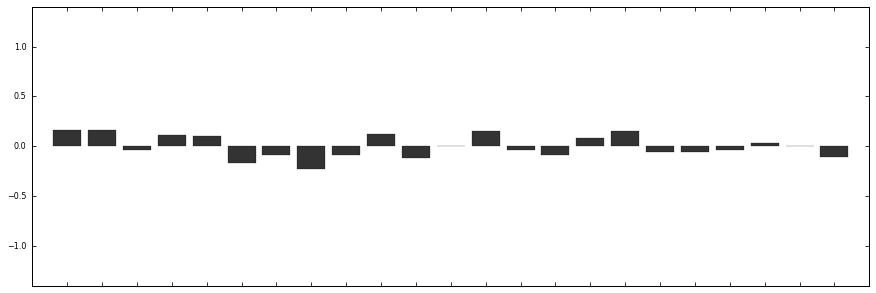

In [17]:
check_event(validate)

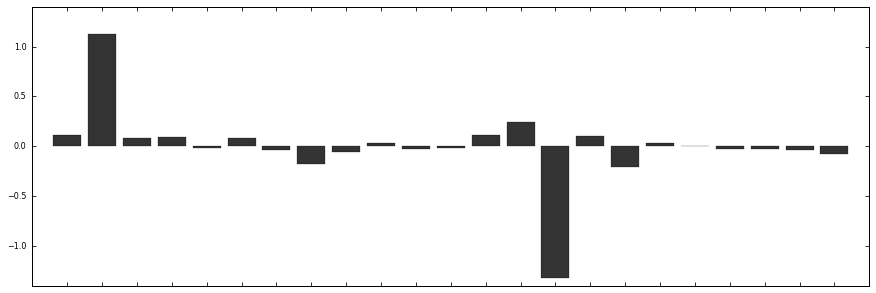

In [18]:
check_event(application)

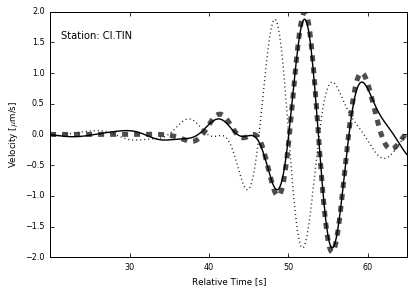

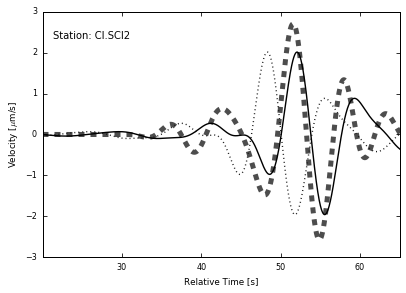

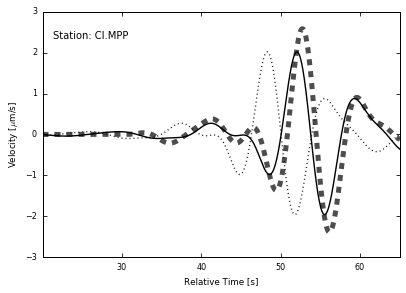

In [19]:
def plot_data(event, station, show=True, legend=False):
    val = data[obspy.core.event.ResourceIdentifier(event)]
    obs = val["processed_observed_stream"].select(station=station)[0]
    syn = val["processed_synthetic_stream"].select(station=station)[0]

    plt.plot(obs.times(), obs.data * 1E6, color="0.3", linestyle="--", linewidth=5,
             label="Observed Data")
    plt.plot(syn.times(), syn.data * 1E6, color="0.1", linestyle=":", label="Synthetic Data")
    
    ts= original_cs[(original_cs.event == validate) &
                    (original_cs.station == "TIN")].time_shift
    
    plt.plot(syn.times() - float(ts), syn.data * 1E6, color="k", label="Shifted Synthetic Data")
    plt.ylabel("Velocity [$\mu$m/s]")
    plt.xlabel("Relative Time [s]")
    plt.xlim(20, 65)
    
    plt.xticks([30, 40, 50, 60], ["30", "40", "50", "60"])
    
    if legend:
        plt.legend(loc="lower left")
        
    plt.text(0.03, 0.92, "Station: CI.%s" % station, transform=plt.gca().transAxes, va="top")
    if show:
        plt.show()
    
plot_data(validate, "TIN")
plot_data(validate, "SCI2")
plot_data(validate, "MPP")

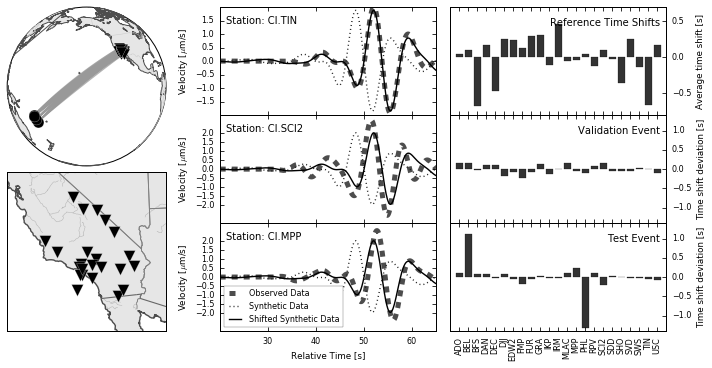

In [20]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 5))

gs1 = gridspec.GridSpec(2, 1, wspace=0, hspace=0.04, left=0, right=0.27, bottom=0.08, top=0.98)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])


gs2 = gridspec.GridSpec(3, 1, wspace=0, hspace=0, left=0.32, right=0.62, bottom=0.08, top=0.98)
ax3 = fig.add_subplot(gs2[0])
ax4 = fig.add_subplot(gs2[1])
ax5 = fig.add_subplot(gs2[2])

gs3 = gridspec.GridSpec(3, 1, wspace=0, hspace=0, left=0.64, right=0.94, bottom=0.08, top=0.98)
ax6 = fig.add_subplot(gs3[0])
ax7 = fig.add_subplot(gs3[1])
ax8 = fig.add_subplot(gs3[2])




station_lats = [sta.latitude for net in filtered_inv for sta in net]
station_lngs = [sta.longitude for net in filtered_inv for sta in net]

ev_lats = [event.origins[0].latitude for event in cat]
ev_lngs = [event.origins[0].longitude for event in cat]


m_ortho = Basemap(resolution='c', projection='ortho', lat_0=10.,
                  lon_0=-150., ax=ax1)
m_ortho.drawcoastlines(color="0.3", linewidth=1.0)
m_ortho.drawcountries(color="0.8")
m_ortho.fillcontinents(color="0.9")

_xs, _ys = m_ortho(station_lngs, station_lats)
_xe, _ye = m_ortho(ev_lngs, ev_lats)

for sta, ev in itertools.product(zip(station_lngs, station_lats),
                                 zip(ev_lngs, ev_lats)):
    m_ortho.drawgreatcircle(*sta, *ev, linewidth=1.2,
                            color="0.6", alpha=0.5)

m_ortho.scatter(_xs, _ys, marker="v", s=120, zorder=10,
                color="k", edgecolor="w")
m_ortho.scatter(_xe, _ye, marker="o", s=120, zorder=10,
                color="k", edgecolor="w")


deg2m = 2 * np.pi * 6371 * 1000 / 360
m_local = Basemap(projection='aea',
                  resolution="i",
                  area_thresh=1000.0, lat_0=34.9,
                  lon_0=-118,
                  width=deg2m * 8, height=deg2m * 8,
                  ax=ax2) 
m_local.drawmapboundary()
m_local.drawrivers(color="0.7")
m_local.drawcoastlines(color="0.3", linewidth=1.4)
m_local.drawcountries(color="0.4", linewidth=1.1)
m_local.fillcontinents(color="0.9")
m_local.drawstates(color="0.5", linewidth=0.9)

_x, _y = m_local(station_lngs, station_lats)
m_local.scatter(_x, _y, marker="v", s=140, zorder=10,
                color="k", edgecolor="w")


# Waveforms.
plt.sca(ax3)
plot_data(validate, "TIN", show=False)
plt.yticks(np.linspace(-1.5, 1.5, 7))

plt.sca(ax4)
plot_data(validate, "SCI2", show=False)
plt.yticks(np.linspace(-2, 2, 9))


plt.sca(ax5)
plot_data(validate, "MPP", show=False, legend=True)
plt.yticks(np.linspace(-2, 2, 9))


plt.sca(ax6)
stations = list(reference_shifts.keys())
delays = [reference_shifts[_i] for _i in stations]
plt.bar(np.arange(len(delays)) - 0.4, delays, 0.8, color="0.2")
plt.xticks(range(len(delays)), [""] * len(delays))
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
plt.xlim(-1, 23)
plt.ylim(-0.8, 0.7)
plt.yticks([-0.5, 0, 0.5])
plt.ylabel("Average time shift [s]")
plt.text(0.97, 0.90, "Reference Time Shifts", transform=plt.gca().transAxes, va="top", ha="right")



plt.sca(ax7)
check_event(validate, ax=ax7)
ax7.yaxis.tick_right()
ax7.yaxis.set_label_position("right")
plt.yticks(np.linspace(-1.0, 1.0, 5))
plt.ylabel("Time shift deviation [s]")
plt.text(0.97, 0.90, "Validation Event", transform=plt.gca().transAxes, va="top", ha="right")




plt.sca(ax8)
check_event(application, ax=ax8, ticks=True)
ax8.yaxis.tick_right()
ax8.yaxis.set_label_position("right")
plt.yticks(np.linspace(-1.0, 1.0, 5))
plt.ylabel("Time shift deviation [s]")
plt.text(0.97, 0.90, "Test Event", transform=plt.gca().transAxes, va="top", ha="right")


plt.savefig("data_quality.pdf")
plt.show()